# Capstone Project - Segmentation and Analysis of Kansas City
### Applied Data Science Capstone by IBM

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

In this project we will try to find the optimal neighborhoods for investing in a business. More particularly, we will be analyzing the prospects for opening a **warehouse or manufacturing facility** in **Kansas City, MO.**

Because Kansas City is already a hub for lots of businesses in the Midwest, we will try to look for **areas similar to those holding manufacturing concerns**. We are also particularly interested in **areas without too many consumer-facing businesses in them**. Last, all else being equal, we will prefer areas that **have manufacturing concerns but are not yet fully developed industrial districts**, because those areas will be the best investment opportunities. If a district is already complete full of factories and warehouses, there's more competition for space and little value add to building there.

We will be using clustering to determine similarity between the business profiles of given neighborhoods. We are looking for a neighborhood that meets our profile, is not already crowded with similar businesses, in which an effective investment can hopefully be made relatively cheaply.

## Data <a name="data"></a>

Based on definition of our problem, factors that will influence our decission are:
* similarity of business environment to other neighborhoods with established manufacturing concerns
* number and type of consumer-facing businesses in the area, which indicates a bad fit
* relative lack of competition

We're going to use a grid method using longitude and latitude to blanket the city and its surrounding area with waypoints. This makes sure that we are not missing anything, and that any information about the business climate in a given geographical area will be captured in our analysis.

The number and type of businesses close to a given longitude and latitude will be obtained using the  **Foursquare API**. This will allow us to make an API call to get a list of up to fifty businesses close to a given waypoint for us to do our analysis with.

### Neighborhoods
We first need to generate a list of longitude and latitude pairs for the centers of each area under consideration. This has the rough effect of randomly sampling as you go outwards from the city center, as where exactly the latitude/longitude pair lands is random, as is which businesses happen to be closest to it; on average, having used a good number of them, we should have sufficient data to cluster them reliably and visualize our different business climates on a map.

First we want the longitude and latitude listed for Kansas City itself; this can be gotten from a call to the Nominatim library, like so.

In [1]:
#import the Nomionatim geocoder
from geopy.geocoders import Nominatim
#Get the latitude and longitude from the address
geolocator = Nominatim(user_agent="kc_explorer")
location = geolocator.geocode("Kansas City, MO")
kc_center = [location.latitude, location.longitude]
print("The geographical coordinates of Kansas City are {}, {}".format(kc_center[0],kc_center[1]))

The geographical coordinates of Kansas City are 39.100105, -94.5781416


In order to create a grid of coordinates running outwards from the area considered the 'center' of the city, we need to be able to change distances back and forth between linear distance on x/y coordinates and latitude/longitude pairs. We'll set up some functions to do that, and then convert our city center over into x/y coordinates from longitude and latitude.

In [2]:
import math
import pyproj

#function to convert longitudes/latitudes into x/y coordinates
def lonlat_to_xy(lon, lat):
    proj_latlon = pyproj.Proj(proj='latlong',datum='WGS84')
    proj_xy = pyproj.Proj(proj="utm", zone=33, datum='WGS84')
    xy = pyproj.transform(proj_latlon, proj_xy, lon, lat)
    return xy[0], xy[1]

#function to convert x/y coordinates back into longitudes and latitudes
def xy_to_lonlat(x, y):
    proj_latlon = pyproj.Proj(proj='latlong',datum='WGS84')
    proj_xy = pyproj.Proj(proj="utm", zone=33, datum='WGS84')
    lonlat = pyproj.transform(proj_xy, proj_latlon, x, y)
    return lonlat[0], lonlat[1]

#function to calculate distances
def calc_xy_distance(x1, y1, x2, y2):
    dx = x2 - x1
    dy = y2 - y1
    return math.sqrt(dx*dx + dy*dy)

Next we create our grid of coordinate cells, each one of which we can use to define a 'neighborhood'. Because the distance between them is relatively small, and because they overlap, each one corresponds closely to a city block. When several nearby blocks form a cohesive group, we can say with confidence that we've identified a 'neighborhood' that has a given business climate.

In [3]:
# Initialize lists to hold our long/lat data, its x/y equivalent, and distances for our points
latitudes = []
longitudes = []
distances_from_center = []
xs = []
ys = []

# generate x/y coordinates for our center
kc_x, kc_y = lonlat_to_xy(kc_center[1], kc_center[0]) 

#Use a step function and distance calculations to calculate the long/lats of our points in a loop
k = math.sqrt(3) / 2 
x_min = kc_x - 12000
x_step = 600
y_min = kc_y - 12000 - (int(64/k)*k*600 - 24000)/2
y_step = 600 * k 

for i in range(0, int(64/k)):
    y = y_min + i * y_step
    x_offset = 300 if i%2==0 else 0
    for j in range(0, 64):
        x = x_min + j * x_step + x_offset
        distance_from_center = calc_xy_distance(kc_x, kc_y, x, y)
        if (distance_from_center <= 12001):
            lon, lat = xy_to_lonlat(x, y)
            latitudes.append(lat)
            longitudes.append(lon)
            distances_from_center.append(distance_from_center)
            xs.append(x)
            ys.append(y)

Now we should graph these grid points to make sure our values look reasonable. What we're looking for is a circle with a large number of smaller circles in it, starting at the city center and expanding outwards until we make it to the outside edge of how far we have chosen to extend our analysis. This is, effectively, a hex grid that blankets the entire city, and which we can use to gather data with later.

In [4]:
import folium
map_kc = folium.Map(location=kc_center, zoom_start=11)
folium.Marker(kc_center, popup='Kansas City Center').add_to(map_kc)
for lat, lon in zip(latitudes, longitudes):
    folium.Circle([lat, lon], radius=300, color='blue', fill=False).add_to(map_kc)
map_kc

Now we can put these all into a pandas dataframe. We could append addresses to each entry, but that's unnecessary; we're only really interested in specific addresses for locations we'll single out later, and we can go get them at that time once we've identified those areas. Moreover, it seems unlike that having 1400-some odd addresses really does us any good; the point of doing analysis is to take a large amount of data and to condense it into something usable.

So instead instead of assigning addresses to them, we'll simply number our areas. This has one further advantage; because we have so many different waypoints, we would have to perform upwards of a thousand API calls in order to label them all with addresses, which would be a significant increase in runtime to do this sort of analysis for little or no value add.

In [5]:
import pandas as pd

df_grid = pd.DataFrame({'Neighborhood_ID': range(len(latitudes)),
                            'Latitude': latitudes,
                             'Longitude': longitudes,
                             'X': xs,
                             'Y': ys,
                             'Distance': distances_from_center})

df_grid.head(10)

,Neighborhood_ID,Latitude,Longitude,X,Y,Distance
0,0,39.120750,-94.487143,-5.444828e+06,1.247817e+07,11999.062463
1,1,39.123973,-94.489453,-5.444228e+06,1.247817e+07,11878.446868
2,2,39.127197,-94.491764,-5.443628e+06,1.247817e+07,11787.175234
3,3,39.130421,-94.494075,-5.443028e+06,1.247817e+07,11725.932799
4,4,39.133645,-94.496386,-5.442428e+06,1.247817e+07,11695.191320
5,5,39.136869,-94.498698,-5.441828e+06,1.247817e+07,11695.191320
6,6,39.140094,-94.501010,-5.441228e+06,1.247817e+07,11725.932799
7,7,39.143318,-94.503323,-5.440628e+06,1.247817e+07,11787.175234
8,8,39.146543,-94.505636,-5.440028e+06,1.247817e+07,11878.446868
9,9,39.149768,-94.507949,-5.439428e+06,1.247817e+07,11999.062463


### Foursquare
In this section we'll query foursquare for each of our chosen points. This will get us a list of nearby businesses, giving a reasonable measure of the business climate in for each of our areas. 

Expanding the radius of our query out to 500, from the 300 we used to initially visualize our districts, accomplishes two things. First, it allows us to make sure that areas with a relatively sparse set of businesses in them still aggregate sufficient data to perform our analysis with more often than not. Second, by increasing the amount of overlap between each area we increase the similarity of nearby districts, which will help us to make sure that the final analysis delivers us clusters that show us what a given area is actually like, as opposed to giving us results that are coincidental to what is close to our long/lat pair. Neighborhoods should resemble those close to them more, and change gradually over with distance.

In [6]:
import requests
LIMIT = 100
radius = 500

CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [7]:
# Declaring some functions to do our neighborhood analysis with.
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        try: # Sometimes foursquare returns bad data. We move on when this happens.
            results = requests.get(url).json()["response"]['groups'][0]['items']
        except KeyError:
            continue
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood_ID', 
                  'Neighborhood Latitude',
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    return(nearby_venues)

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [8]:
kc_venues = getNearbyVenues(names=df_grid['Neighborhood_ID'],
                                   latitudes=df_grid['Latitude'],
                                   longitudes=df_grid['Longitude']
                                  )
kc_venues.head()

A KeyError happened
A KeyError happened


,Neighborhood_ID,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,0,39.120750,-94.487143,Harrah's Casino Lunchroom,39.116575,-94.487740,Restaurant
1,1,39.123973,-94.489453,Penske Truck Rental,39.127079,-94.488601,Rental Car Location
2,1,39.123973,-94.489453,Ferguson Waterworks,39.126006,-94.487885,Lighting Store
3,2,39.127197,-94.491764,Penske Truck Rental,39.127079,-94.488601,Rental Car Location
4,3,39.130421,-94.494075,Goodyear,39.131332,-94.495900,Auto Garage


## Methodology<a name="methodology"></a>
In this project we will be looking for areas that are friendly to establishing manufacturing concerns, but which are not already crowded with them. We are analyzing an area within twelve kilometers of the center of the city, which assures a new business of access to the local labor market. 

In our first step we've collected the required data. We've successfully gotten a list of venues for each of our neighborhood blocks. Our output shows that our first neighborhood only returned one result and our second two. This assures us that multiple values for each neighborhood are represented in the dataframe. We might be inclined to worry that there won't be enough data for some districts, and this concern is valid. However, we should expect that most locations with little returned data will end up in the same cluster (the close-to-zero cluster), and that's a useful category; these will mostly correspond to residential districts, or other areas that are not particularly friendly to the establishment of large businesses.

We also see two KeyError outputs, which happens when the API returns bad data. Out of 1488 API calls we only have two of these, and they should have a negligible result on our final analysis.

In our next steps we will prepare the data for cluster analysis and identify those which seem promising for investing in the type of businesses we've discussed.

## Analysis<a name="analsysis"></a>
We will begin our analysis by taking the venues dataframe and make a series of one-hot vectors out of our 'venue category' options. We can then group our venues together for each of our neighborhoods so that we can perform k-means clustering and map it onto the city.

In [9]:
import numpy as np
from sklearn.cluster import KMeans

In [10]:
kc_onehot = pd.get_dummies(kc_venues[['Venue Category']], prefix="", prefix_sep="")

kc_onehot.head()
#add neighborhood column back to dataframe
kc_onehot['Neighborhood_ID'] = kc_venues['Neighborhood_ID'] 

#move neighborhood column to the first column
fixed_columns = [kc_onehot.columns[-1]] + list(kc_onehot.columns[:-1])
kc_onehot = kc_onehot[fixed_columns]

kc_onehot.head()

,Neighborhood_ID,ATM,Accessories Store,Airport,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Arcade,...,Volleyball Court,Warehouse Store,Waste Facility,Water Park,Wedding Hall,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
# Grouping
kc_grouped = kc_onehot.groupby('Neighborhood_ID').mean().reset_index()
kc_grouped

,Neighborhood_ID,ATM,Accessories Store,Airport,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Arcade,...,Volleyball Court,Warehouse Store,Waste Facility,Water Park,Wedding Hall,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,5,0.0,0.0,0.0,0.0,0.0,0.250000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,6,0.0,0.0,0.0,0.0,0.0,0.250000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,7,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,9,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,10,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Before we run our k-means clustering, it's helpful to have a good idea how to get output for each of our neighborhoods. We can do this fairly simply, by taking the frequencies in our grouped dataframe and simply putting them in a new dataframe from highest to lowest. We will later use the same approach to characterize entire clusters; having over a thousand of these is so much inforamtion that it is close to useless, but using the same approach on clustered data can give us something actionable.

In [12]:
# Starting to analyze
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood_ID']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood_ID'] = kc_grouped['Neighborhood_ID']

for ind in np.arange(kc_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(kc_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood_ID,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,0,Restaurant,Yoga Studio,Film Studio,Event Space,Exhibit,Factory,Farm,Farmers Market,Fast Food Restaurant,Field
1,1,Rental Car Location,Lighting Store,Film Studio,Event Space,Exhibit,Factory,Farm,Farmers Market,Fast Food Restaurant,Field
2,2,Rental Car Location,Financial or Legal Service,Event Space,Exhibit,Factory,Farm,Farmers Market,Fast Food Restaurant,Field,Film Studio
3,3,Moving Target,Auto Garage,Gas Station,Yoga Studio,Financial or Legal Service,Factory,Farm,Farmers Market,Fast Food Restaurant,Field
4,4,Thrift / Vintage Store,Auto Garage,Business Service,Gas Station,Yoga Studio,Exhibit,Factory,Farm,Farmers Market,Fast Food Restaurant


Now we'll run k-means repeatedly to determine how many clusters we want. The fast way to do this is simply to run k-means with a different k for a respectable range and compare the aggregated statistics of the output. We'll be running histograms of cluster assignments for each K, and also plotting the error against K to see what we can determine about the results for each K. This gives us the opportunity to compare the usefulness of different values of K.

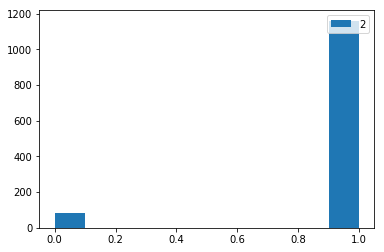

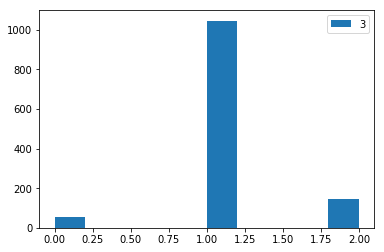

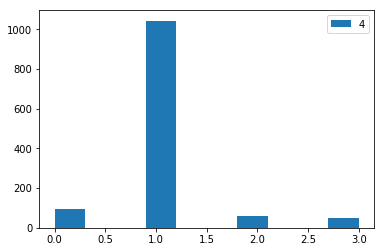

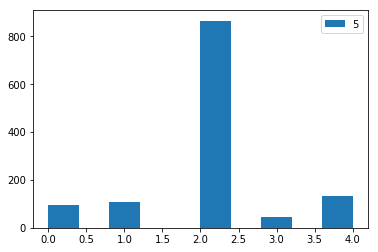

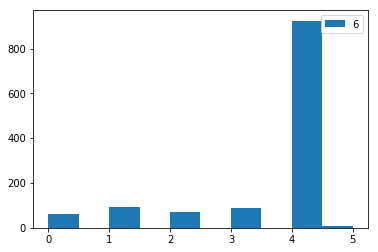

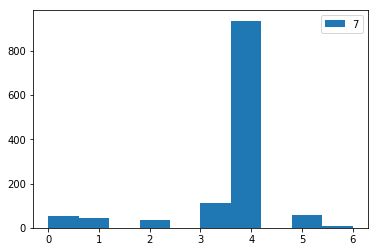

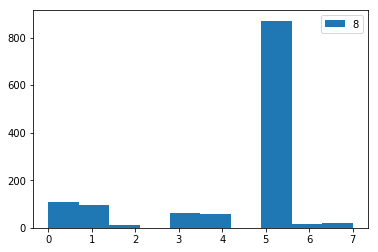

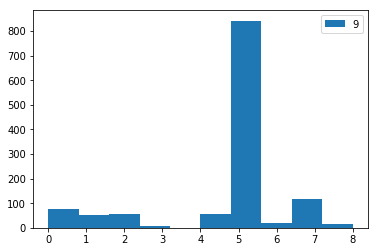

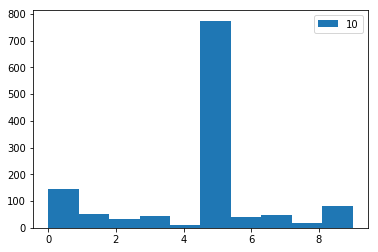

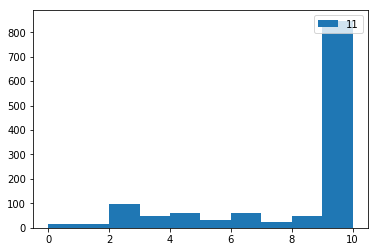

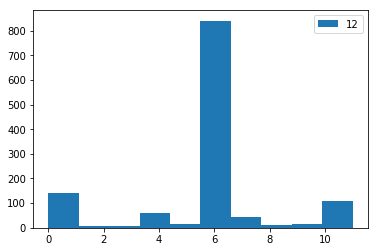

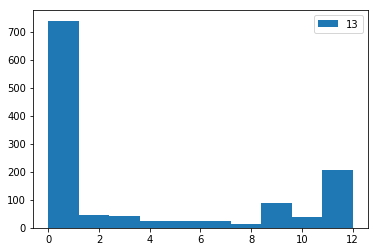

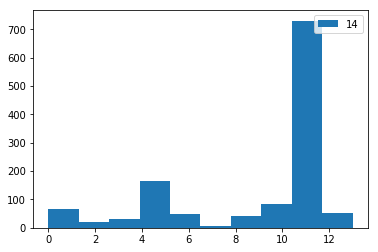

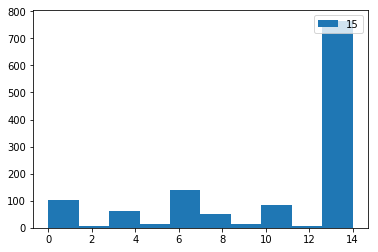

In [13]:
# Running K-means
%matplotlib inline
from matplotlib import pyplot as plt

kc_grouped_clustering = kc_grouped.drop('Neighborhood_ID', 1)

# run k-means clustering
klist = range(2,16)
err = []

for k in klist:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(kc_grouped_clustering)
    err.append(kmeans.score(kc_grouped_clustering))
    plt.hist(kmeans.predict(kc_grouped_clustering), label=str(k))
    plt.legend(loc="upper right")
    plt.show()
# check cluster labels generated for each row in the dataframe

<function matplotlib.pyplot.show(*args, **kw)>

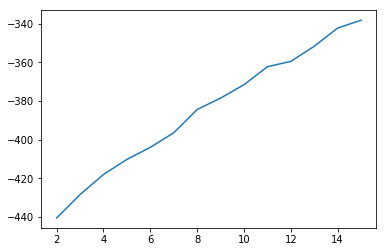

In [14]:
plt.plot(klist,err)
plt.show

This second plot of the error against the value of k is what is normally used for the 'elbow test'. Unfortunately, our data shows no such elbow; increasing k seems to produce a linear reduction in error all the way up to 15, where we are approaching so many clusters that it does not form useful information for a decision-maker. So we cannot use the 'elbow test' to determine how many clusters we want.

Instead, we can look at the histograms of our cluster assignments to make a determination. We see, across every k, that there is one cluster that has most of our results; this will probably be the 'close to zero' cluster, which categorizes residential areas and areas that are not particularly business-friendly. As k increases, new clusters all have a reasonable number of neighborhoods assigned to them up to k = 6, where see our newly-added cluster 5 has almost no members.

This is a sign that at k = 6 and above we should have enough clusters, because adding new ones is no longer generating more well-populated clusters. We're worried about having too few clusters more than too many, so setting k = 8 is a good value to be sure we're getting the information we need.

In [15]:
# setting our k so that we can run our actual analysis
kclusters = 8
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(kc_grouped_clustering)

Here we add our cluster labels onto our original dataframe of neighborhoods.

After that we have to drop rows that don't have a cluster label; this will correspond to the two values where the API returned bad data for a KeyError, and to over two hundred values that returned no businesses within 500 meters. These areas are, mostly for reasons of geography, not hospitable to adding businesses, and so excluding them from our cluster analysis is a good preliminary step.

In [16]:
# add clustering labels

neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

kc_merged = df_grid

# merge kc_grouped with kc_data to add latitude/longitude for each neighborhood
kc_merged = kc_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood_ID'), on='Neighborhood_ID')

kc_merged = kc_merged[kc_merged['Cluster Labels'].isna() == False]

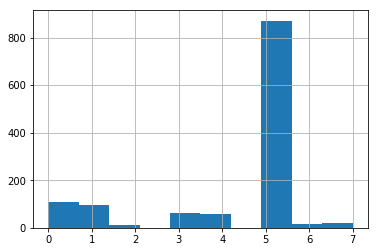

In [17]:
kc_merged['Cluster Labels'].hist()

And now, last but not least, we'll put our clusters on a map.

In [18]:
# create map
map_clusters = folium.Map(location=kc_center, zoom_start=12)
import matplotlib.colors as colors
import matplotlib.cm as cm
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(kc_merged['Latitude'], kc_merged['Longitude'], kc_merged['Neighborhood_ID'], kc_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [19]:
kc_merged.groupby(['Cluster Labels']).agg(lambda x: pd.Series.mode(x).values[0])

,Neighborhood_ID,Latitude,Longitude,X,Y,Distance,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Cluster Labels,,,,,,,,,,,,,,,,
0.0,16,39.035046,-94.669837,-5.442728e+06,1.248440e+07,2357.435047,Convenience Store,Convenience Store,Fast Food Restaurant,Event Space,Factory,Factory,Factory,Farm,Farmers Market,Film Studio
1.0,97,39.051876,-94.667914,-5.444528e+06,1.249635e+07,6739.992582,Mexican Restaurant,Mexican Restaurant,Mexican Restaurant,Yoga Studio,Yoga Studio,Factory,Farm,Farmers Market,Fast Food Restaurant,Field
2.0,131,39.080394,-94.660765,-5.443028e+06,1.249220e+07,4416.729559,Train Station,Yoga Studio,Film Studio,Event Space,Exhibit,Factory,Farm,Farmers Market,Fast Food Restaurant,Field
3.0,18,39.051220,-94.669919,-5.452328e+06,1.248180e+07,7587.983922,Construction & Landscaping,Food Service,Event Space,Exhibit,Factory,Farm,Farmers Market,Fast Food Restaurant,Field,Film Studio
4.0,121,39.028837,-94.665504,-5.449028e+06,1.248336e+07,4426.906369,Park,Yoga Studio,Yoga Studio,Exhibit,Factory,Farm,Farmers Market,Fast Food Restaurant,Field,Film Studio
5.0,0,39.028793,-94.672413,-5.445428e+06,1.249168e+07,396.862697,Park,Yoga Studio,Financial or Legal Service,Exhibit,Factory,Farm,Farmers Market,Fast Food Restaurant,Field,Film Studio
6.0,57,39.064587,-94.643616,-5.443928e+06,1.248024e+07,4918.078893,Business Service,Yoga Studio,Food Service,Exhibit,Factory,Farm,Farmers Market,Fast Food Restaurant,Field,Film Studio
7.0,140,39.048698,-94.642232,-5.448128e+06,1.248908e+07,3803.616700,Gym,Yoga Studio,Film Studio,Event Space,Exhibit,Factory,Farm,Farmers Market,Fast Food Restaurant,Field


## Results and discussion<a name="results"></a>
Our analysis shows right away a number of areas we can rule out, and several that we will want to give further consideration. Areas without cluster markers are those for which the Foursquare API did not return viable data, and we can see on the map that these areas are rightfully excluded as corresponding mostly to rivers and other geographical features which would make locating a large business concern there prohibitive.

Similarly, our largest cluster is cluster five. This is our 'close to zero' cluster, in other words clusters with low total business density. These show a heavy bias towards venues meant for residential districts like parks and legal studios. Every one of our clusters shows 'factory' as one of its more common venues, reflecting Kansas City's position as a manufacturing hub. This reflects Kansas City's desirability for manfuacturing concerns generally, but for selecting a specific place to locate a new plant we can rule out cluster five as a particularly good investment.

Cluster seven shows up primarily in the Fairfax Industrial District. We can learn from this that cluster seven has identified prominent industrial areas. Based upon our criteria of selecting a less-developed area for development we can rule out the Fairfax Industrial District itself. However, we can pinpoint the other neighborhoods assigned cluster seven as being similar in character, and so they point us to opportunities in a small clusters on the east, northeast, and southwest of the city.

For the remainder of our clusters we can prioritize those that border neighborhoods marked cluster seven, specifically the large area of cluster one on the west and another in the southwest of the city, then the areas of cluster four to the northeast and east. Because they are not in our 'catchall' cluster five, and because the border areas marked as similar to the Fairfax Industrial District, we can pinpoint them as meeting both our criteria for business-friendliness and also being as-yet not heavily invested in.

Last but not least we will want to exclude cluster zero; it is distinct from our 'residential' cluster five, but shows a heavy prevalence of factories in the modes of our nth most common venues, indicating a level of prior investment that makes future investment seem not to be promising.

## Conclusion <a name="conclusion"></a>
Our purpose in this project was to identify areas of interest for investment in heavy manufacturing and warehousing in Kansas City. We've identified a number of promising prospects. These areas can be thought of as meeting a sort of 'goldilocks' criteria, being neither so heavily invested that further investment is unlikely to be cost-effective, nor so sparsely industrialized as to be likely unfriendly to businesses. Clustering allows us to quickly identify these areas of interest, providing good starting points for stakeholders to investigate for future opportunities.

Ultimately stakeholders can use this information to make a decision. This will depend upon the specific considerations of each area, including the availability and price of real estate, regulatory and zoning authorities, and access to labor. Using our analysis as a starting point for the process can accelerate and inform this decision-making along the way by providing a map of the available opportunities.